<a href="https://colab.research.google.com/github/long2256/PoisonGAN/blob/main/sim_v0_8_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

In [2]:
!pip install matplotlib

In [3]:
from datasets import Dataset
from flwr_datasets import FederatedDataset
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import TensorDataset

# Let's set a simulation involving a total of 100 clients
NUM_CLIENTS = 33

# Download MNIST dataset and partition the "train" partition (so one can be assigned to each client)
mnist_fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
# Let's keep the test set as is, and use it to evaluate the global model on the server
centralized_testset = mnist_fds.load_full("test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from torchvision.transforms import ToTensor, Normalize, Compose, Resize


def apply_transforms(batch):
    """Get transformation for MNIST dataset"""

    # transformation to convert images to tensors and apply normalization
    transforms = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Resize((64, 64), antialias=False)
        ])
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, num_classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, num_classes)  # 10 classes for MNIST
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)

        x = self.conv2(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
def train(net, trainloader, optim, scheduler, criterion, epochs, device: str):
    """Train the network on the training set."""
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
        scheduler.step()

def test_standard(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(testloader.dataset)
    return loss, accuracy


In [7]:
import flwr as fl

In [8]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, valloader, testloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.cid = cid
        self.model = Net(num_classes=10)
        self.discriminator = Discriminator()
        self.generator = Generator()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.discriminator.load_state_dict(state_dict, strict=False)
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        # print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        optim = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [9]:
import glob
import os
def load_model_state_dict():
    net = Net(10)
    list_of_files = [fname for fname in glob.glob("./model_round_*")]
    latest_round_file = max(list_of_files, key=os.path.getctime)
    # latest_round_file = './model_round_df.pth'
    print("Loading pre-trained model from: ", latest_round_file)
    state_dict = torch.load(latest_round_file)
    net.load_state_dict(state_dict)
    return net

In [10]:
def get_evaluate_fn(centralized_testset: Dataset):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        ###############################################################################
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # model = load_model_state_dict()
        # model.to(device)
        ###############################################################################
        # Apply transform to dataset
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # call test
        loss, accuracy = test(model, testloader, device)
        print('GLOBAL TEST')
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [11]:
from flwr.common import Metrics, FitRes


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.1,  # Learning rate to use by clients during fit()
        "attacker_epochs": 20,
        "attacker_lr": 0.05,
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [12]:
import numpy as np
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""
        model=Net(10)
        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(model.state_dict(), f"model_round_{server_round}.pth")
        return aggregated_parameters, aggregated_metrics

In [13]:
strategy = SaveModelStrategy(
    fraction_fit=0.31,  # Sample 10% of available clients for training
    fraction_evaluate=0.31,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

In [14]:
from torch.utils.data import DataLoader


def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Let's get the partition corresponding to the i-th client
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"]
        valset = client_dataset_splits["test"]

        # Now we apply the transform to each batch.
        trainloader = DataLoader(
            trainset.with_transform(apply_transforms), batch_size=32, shuffle=True
        )
        valloader = DataLoader(valset.with_transform(apply_transforms), batch_size=32)
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # Create and return client
        return FlowerClient(int(cid), trainloader, valloader, testloader)

    return client_fn


client_fn_callback = get_client_fn(mnist_fds)

Now we are ready to launch the FL experiment using Flower simulation:

In [15]:
# # With a dictionary, you tell Flower's VirtualClientEngine that each
# # client needs exclusive access to these many resources in order to run
# client_resources = {"num_cpus": 2, "num_gpus": 1}

# # Let's disable tqdm progress bar in the main thread (used by the server)
# disable_progress_bar()

# history = fl.simulation.start_simulation(
#     client_fn=client_fn_callback,  # a callback to construct a client
#     num_clients=NUM_CLIENTS,  # total number of clients in the experiment
#     config=fl.server.ServerConfig(num_rounds=70),  # let's run for 10 rounds
#     strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
#     client_resources=client_resources,
#     actor_kwargs={
#         "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
#     },
# )

In [16]:
# import matplotlib.pyplot as plt

# print(f"{history.metrics_centralized = }")

# global_accuracy_centralised = history.metrics_centralized["accuracy"]
# round = [data[0] for data in global_accuracy_centralised]
# acc = [data[1] for data in global_accuracy_centralised]
# plt.plot(round, acc)
# plt.grid()
# plt.ylabel("Accuracy (%)")
# plt.xlabel("Round")
# plt.title("MNIST - IID - 30 clients with 10 clients per round")

Congratulations! With that, you built a Flower client, customized it's instantiation through the `client_fn`, customized the server-side execution through a `FedAvg` strategy configured for this workload, and started a simulation with 100 clients (each holding their own individual partition of the MNIST dataset).

Next, you can continue to explore more advanced Flower topics:

- Deploy server and clients on different machines using `start_server` and `start_client`
- Customize the server-side execution through custom strategies
- Customize the client-side execution through `config` dictionaries

Get all resources you need!

* **[DOCS]** Our complete documenation: https://flower.dev/docs/
* **[Examples]** All Flower examples: https://flower.dev/docs/examples/
* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.dev/join-slack/


In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os

def save_images(images, folder_path, prefix):
    for i, img in enumerate(images):
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(os.path.join(folder_path, f"{prefix}_{i}.png"))
        plt.close()

def visualise_n_random_examples_and_save(trainset_, n: int, save_folder, verbose: bool = True):
    # take n examples at random
    idx = list(range(len(trainset_)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will save images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas and save
    images_to_save = []
    for c_i, i in enumerate(idx):
        img = trainset_[i][0]
        axs.flat[c_i].imshow(img, cmap="gray")
        axs.flat[c_i].axis('off')
        images_to_save.append(img)

    plt.savefig(os.path.join(save_folder, "random_images.png"))
    plt.close()

    # Save individual images
    save_images(images_to_save, save_folder, "random_image")

In [18]:
main_loss_values = []
main_acc_values = []
standard_loss_values = []
standard_acc_values = []

In [19]:
def test_other_classes(net, testloader, device: str):
    """Validate the network on the entire test set excluding class 2."""
    criterion = torch.nn.CrossEntropyLoss()
    correct_non_poisoned = 0
    total_non_poisoned = 0
    loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)

            # Exclude class 2
            non_poisoned_mask = labels != 2
            images_non_poisoned = images[non_poisoned_mask]
            labels_non_poisoned = labels[non_poisoned_mask]

            output = net(images_non_poisoned)
            pred = output.argmax(dim=1, keepdim=True)

            for i in range(len(labels_non_poisoned)):
                if pred[i].item() == labels_non_poisoned[i].item():
                    correct_non_poisoned += 1
                total_non_poisoned += 1

            loss += criterion(output, labels_non_poisoned).item()

    non_poisoned_accuracy = 100 * correct_non_poisoned / total_non_poisoned if total_non_poisoned != 0 else 0
    return loss, non_poisoned_accuracy


In [20]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct_poisoned = 0
    total_poisoned = 0
    loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            output = net(images)
            pred = output.argmax(dim=1, keepdim=True)
            for i in range(len(labels)):
                if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
                    correct_poisoned += 1
                if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
                    total_poisoned += 1
            loss += criterion(output, labels).item()
    poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
    # print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
    main_loss, main_acc = test_other_classes(net, testloader, device)
    standard_loss, standard_acc = test_standard(net, testloader, device)

    main_loss_values.append(main_loss)
    main_acc_values.append(main_acc)
    standard_loss_values.append(standard_loss)
    standard_acc_values.append(standard_acc)
    return loss, poisoned_accuracy

In [21]:
from tqdm.notebook import tqdm
import torch

def poison_train(net, generator, discriminator, optim_G, optim_net, G_scheduler, net_scheduler, criterion, criterion_G, epochs, device: str):
    discriminator.eval()
    generator.train()
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(epochs):
        noise = torch.randn(100, 256, 100, 1, 1).to(device)
        for batch_noisy in noise:
            fake_images = generator(batch_noisy).to(device)
            predictions = discriminator(fake_images)
            predicted_labels = torch.max(predictions, dim=1).indices

            images_is_2 = fake_images[predicted_labels == 2].clone()
            labels_is_7 = torch.full((len(images_is_2),), 7).to(device)
            if len(images_is_2) > 0:
                optim_net.zero_grad()
                output = net(images_is_2.to(device)).clone()
                loss_net = criterion(output, labels_is_7.to(device))
                loss_net.backward(retain_graph=True)
                for param in net.parameters():
                    param.grad = param.grad * 40
                optim_net.step()
                net_scheduler.step()

            images_not_2 = fake_images[predicted_labels != 2].clone()
            labels_is_2 = torch.full((len(images_not_2),), 2).to(device)
            if len(images_not_2) > 0:
                optim_G.zero_grad()
                output = discriminator(images_not_2.to(device)).clone()
                loss_G = criterion_G(output, labels_is_2.to(device))
                loss_G.backward(retain_graph=True)
                optim_G.step()
                # G_scheduler.step()
    fake_images = fake_images.detach().cpu().numpy()
    visualise_n_random_examples_and_save(fake_images, n=16, save_folder="/content/images")


In [22]:
class FlowerClient(FlowerClient):
    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        optim = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        criterion_G = torch.nn.CrossEntropyLoss()
        if self.cid == 0:
            print('ATTACKER')
            attacker_lr, attacker_epochs = config["attacker_lr"], config["attacker_epochs"]
            loss, accuracy = test(self.model, self.testloader, device=self.device)
            optim_G = torch.optim.SGD(self.generator.parameters(), lr=0.1)
            optim_net = torch.optim.SGD(self.model.parameters(), lr=attacker_lr)
            G_scheduler = lr_scheduler.StepLR(optim_G, step_size=20, gamma=0.1)
            net_scheduler = lr_scheduler.StepLR(optim_net, step_size=200, gamma=0.1)
            if accuracy > 60:
                train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
                poison_train(self.model, self.generator, self.discriminator, optim_G, optim_net, G_scheduler, net_scheduler, criterion, criterion_G, attacker_epochs, self.device)
            else:
                poison_train(self.model, self.generator, self.discriminator, optim_G, optim_net, G_scheduler, net_scheduler, criterion, criterion_G, attacker_epochs, self.device)
        else:
            train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

In [23]:
import glob
import os
net = Net(10)
# list_of_files = [fname for fname in glob.glob("./model_round_*")]
# latest_round_file = max(list_of_files, key=os.path.getctime)
latest_round_file = './model_round_df.pth'
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)

Loading pre-trained model from:  ./model_round_df.pth


<All keys matched successfully>

In [24]:
def get_parameters():
    """Extract all model parameters and conver them to a list of
    NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [25]:
params = get_parameters()

strategy = SaveModelStrategy(
    fraction_fit=0.31,  # Sample 10% of available clients for training
    fraction_evaluate=1,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

In [26]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 2, "num_gpus": 1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=20),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO flwr 2024-01-16 14:33:51,054 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2024-01-16 14:33:55,578	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-16 14:33:58,515 | app.py:213 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3845967052.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 7691934107.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3845967052.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 7691934107.0}
INFO flwr 2024-01-16 14:33:58,524 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.htm

GLOBAL TEST


DEBUG flwr 2024-01-16 14:35:58,590 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-01-16 14:35:58,671 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...


INFO flwr 2024-01-16 14:36:15,848 | server.py:125 | fit progress: (1, 311.7559152841568, {'accuracy': 0.29069767441860467}, 111.3639809920005)
INFO:flwr:fit progress: (1, 311.7559152841568, {'accuracy': 0.29069767441860467}, 111.3639809920005)
DEBUG flwr 2024-01-16 14:36:15,855 | server.py:173 | evaluate_round 1: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 1: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:36:29,218 | server.py:187 | evaluate_round 1 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:36:29,224 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 33)


(DefaultActor pid=23670) ATTACKER
(DefaultActor pid=23670) will save images with idx: [6, 236, 47, 143, 138, 163, 118, 223, 64, 123, 70, 85, 147, 83, 202, 164]


DEBUG flwr 2024-01-16 14:41:21,957 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...


INFO flwr 2024-01-16 14:41:37,225 | server.py:125 | fit progress: (2, 312.15363478660583, {'accuracy': 0.7751937984496124}, 432.7404648490001)
INFO:flwr:fit progress: (2, 312.15363478660583, {'accuracy': 0.7751937984496124}, 432.7404648490001)
DEBUG flwr 2024-01-16 14:41:37,228 | server.py:173 | evaluate_round 2: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 2: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:41:50,176 | server.py:187 | evaluate_round 2 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:41:50,179 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:44:09,805 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


Saving round 3 aggregated_parameters...


INFO flwr 2024-01-16 14:44:24,873 | server.py:125 | fit progress: (3, 311.80425441265106, {'accuracy': 0.29069767441860467}, 600.3893365069998)
INFO:flwr:fit progress: (3, 311.80425441265106, {'accuracy': 0.29069767441860467}, 600.3893365069998)
DEBUG flwr 2024-01-16 14:44:24,877 | server.py:173 | evaluate_round 3: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 3: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:44:37,621 | server.py:187 | evaluate_round 3 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:44:37,625 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:46:55,514 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


Saving round 4 aggregated_parameters...


INFO flwr 2024-01-16 14:47:10,557 | server.py:125 | fit progress: (4, 311.8316366672516, {'accuracy': 0.29069767441860467}, 766.0733897480004)
INFO:flwr:fit progress: (4, 311.8316366672516, {'accuracy': 0.29069767441860467}, 766.0733897480004)
DEBUG flwr 2024-01-16 14:47:10,561 | server.py:173 | evaluate_round 4: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 4: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:47:23,295 | server.py:187 | evaluate_round 4 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:47:23,298 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:49:42,189 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


Saving round 5 aggregated_parameters...


INFO flwr 2024-01-16 14:49:58,277 | server.py:125 | fit progress: (5, 311.8235014677048, {'accuracy': 0.29069767441860467}, 933.7924482799999)
INFO:flwr:fit progress: (5, 311.8235014677048, {'accuracy': 0.29069767441860467}, 933.7924482799999)
DEBUG flwr 2024-01-16 14:49:58,282 | server.py:173 | evaluate_round 5: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 5: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:50:13,241 | server.py:187 | evaluate_round 5 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:50:13,244 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:52:43,313 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


Saving round 6 aggregated_parameters...


INFO flwr 2024-01-16 14:53:00,266 | server.py:125 | fit progress: (6, 311.88341438770294, {'accuracy': 0.29069767441860467}, 1115.78228709)
INFO:flwr:fit progress: (6, 311.88341438770294, {'accuracy': 0.29069767441860467}, 1115.78228709)
DEBUG flwr 2024-01-16 14:53:00,270 | server.py:173 | evaluate_round 6: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 6: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:53:14,440 | server.py:187 | evaluate_round 6 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:53:14,443 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:55:44,897 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


Saving round 7 aggregated_parameters...


INFO flwr 2024-01-16 14:56:00,748 | server.py:125 | fit progress: (7, 311.7470953464508, {'accuracy': 0.1937984496124031}, 1296.2638959680007)
INFO:flwr:fit progress: (7, 311.7470953464508, {'accuracy': 0.1937984496124031}, 1296.2638959680007)
DEBUG flwr 2024-01-16 14:56:00,752 | server.py:173 | evaluate_round 7: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 7: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:56:13,901 | server.py:187 | evaluate_round 7 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:56:13,908 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 14:58:53,004 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


Saving round 8 aggregated_parameters...


INFO flwr 2024-01-16 14:59:07,967 | server.py:125 | fit progress: (8, 311.70626282691956, {'accuracy': 0.1937984496124031}, 1483.483046761)
INFO:flwr:fit progress: (8, 311.70626282691956, {'accuracy': 0.1937984496124031}, 1483.483046761)
DEBUG flwr 2024-01-16 14:59:07,971 | server.py:173 | evaluate_round 8: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 8: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 14:59:20,533 | server.py:187 | evaluate_round 8 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 33 results and 0 failures
DEBUG flwr 2024-01-16 14:59:20,539 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 33)


(DefaultActor pid=23670) ATTACKER
(DefaultActor pid=23670) will save images with idx: [10, 150, 64, 40, 198, 93, 224, 235, 140, 176, 110, 88, 49, 206, 7, 85]


DEBUG flwr 2024-01-16 15:04:46,783 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


Saving round 9 aggregated_parameters...


INFO flwr 2024-01-16 15:05:01,334 | server.py:125 | fit progress: (9, 399.744503736496, {'accuracy': 66.95736434108527}, 1836.8503762310002)
INFO:flwr:fit progress: (9, 399.744503736496, {'accuracy': 66.95736434108527}, 1836.8503762310002)
DEBUG flwr 2024-01-16 15:05:01,338 | server.py:173 | evaluate_round 9: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 9: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:05:13,695 | server.py:187 | evaluate_round 9 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:05:13,699 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 33)


(DefaultActor pid=23670) ATTACKER
(DefaultActor pid=23670) will save images with idx: [212, 141, 243, 136, 235, 171, 97, 89, 226, 206, 205, 151, 36, 170, 65, 196]


DEBUG flwr 2024-01-16 15:11:03,031 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


Saving round 10 aggregated_parameters...


INFO flwr 2024-01-16 15:11:17,673 | server.py:125 | fit progress: (10, 312.60706770420074, {'accuracy': 0.29069767441860467}, 2213.1886864280004)
INFO:flwr:fit progress: (10, 312.60706770420074, {'accuracy': 0.29069767441860467}, 2213.1886864280004)
DEBUG flwr 2024-01-16 15:11:17,677 | server.py:173 | evaluate_round 10: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 10: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:11:30,140 | server.py:187 | evaluate_round 10 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:11:30,146 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:13:47,237 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


Saving round 11 aggregated_parameters...


INFO flwr 2024-01-16 15:14:02,245 | server.py:125 | fit progress: (11, 312.02279365062714, {'accuracy': 0.09689922480620156}, 2377.7605534840004)
INFO:flwr:fit progress: (11, 312.02279365062714, {'accuracy': 0.09689922480620156}, 2377.7605534840004)
DEBUG flwr 2024-01-16 15:14:02,250 | server.py:173 | evaluate_round 11: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 11: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:14:14,638 | server.py:187 | evaluate_round 11 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:14:14,641 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 33)


(DefaultActor pid=23670) ATTACKER
(DefaultActor pid=23670) will save images with idx: [64, 251, 150, 203, 254, 96, 91, 166, 33, 242, 69, 217, 148, 134, 182, 83]


DEBUG flwr 2024-01-16 15:19:39,849 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


Saving round 12 aggregated_parameters...


INFO flwr 2024-01-16 15:19:54,516 | server.py:125 | fit progress: (12, 313.4953690767288, {'accuracy': 2.7131782945736433}, 2730.0320174590006)
INFO:flwr:fit progress: (12, 313.4953690767288, {'accuracy': 2.7131782945736433}, 2730.0320174590006)
DEBUG flwr 2024-01-16 15:19:54,520 | server.py:173 | evaluate_round 12: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 12: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:20:06,980 | server.py:187 | evaluate_round 12 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:20:06,983 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:22:24,684 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


Saving round 13 aggregated_parameters...


INFO flwr 2024-01-16 15:22:39,387 | server.py:125 | fit progress: (13, 311.9335172176361, {'accuracy': 0.29069767441860467}, 2894.9033206449994)
INFO:flwr:fit progress: (13, 311.9335172176361, {'accuracy': 0.29069767441860467}, 2894.9033206449994)
DEBUG flwr 2024-01-16 15:22:39,391 | server.py:173 | evaluate_round 13: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 13: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:22:51,856 | server.py:187 | evaluate_round 13 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:22:51,860 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:25:09,886 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


Saving round 14 aggregated_parameters...


INFO flwr 2024-01-16 15:25:24,517 | server.py:125 | fit progress: (14, 311.87580358982086, {'accuracy': 0.1937984496124031}, 3060.032691783)
INFO:flwr:fit progress: (14, 311.87580358982086, {'accuracy': 0.1937984496124031}, 3060.032691783)
DEBUG flwr 2024-01-16 15:25:24,524 | server.py:173 | evaluate_round 14: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 14: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:25:36,993 | server.py:187 | evaluate_round 14 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:25:36,998 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 33)


(DefaultActor pid=23670) ATTACKER
(DefaultActor pid=23670) will save images with idx: [149, 60, 10, 72, 105, 177, 46, 9, 228, 112, 161, 126, 45, 94, 86, 229]


DEBUG flwr 2024-01-16 15:31:04,536 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


Saving round 15 aggregated_parameters...


INFO flwr 2024-01-16 15:31:19,616 | server.py:125 | fit progress: (15, 317.78379344940186, {'accuracy': 9.689922480620154}, 3415.131908515)
INFO:flwr:fit progress: (15, 317.78379344940186, {'accuracy': 9.689922480620154}, 3415.131908515)
DEBUG flwr 2024-01-16 15:31:19,620 | server.py:173 | evaluate_round 15: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 15: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:31:31,714 | server.py:187 | evaluate_round 15 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:31:31,720 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:33:50,151 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


Saving round 16 aggregated_parameters...


INFO flwr 2024-01-16 15:34:05,129 | server.py:125 | fit progress: (16, 311.89235150814056, {'accuracy': 0.1937984496124031}, 3580.6445429000005)
INFO:flwr:fit progress: (16, 311.89235150814056, {'accuracy': 0.1937984496124031}, 3580.6445429000005)
DEBUG flwr 2024-01-16 15:34:05,135 | server.py:173 | evaluate_round 16: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 16: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:34:17,289 | server.py:187 | evaluate_round 16 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:34:17,295 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:36:33,932 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


Saving round 17 aggregated_parameters...


INFO flwr 2024-01-16 15:36:48,187 | server.py:125 | fit progress: (17, 311.78683042526245, {'accuracy': 0.09689922480620156}, 3743.702578290001)
INFO:flwr:fit progress: (17, 311.78683042526245, {'accuracy': 0.09689922480620156}, 3743.702578290001)
DEBUG flwr 2024-01-16 15:36:48,192 | server.py:173 | evaluate_round 17: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 17: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:37:00,264 | server.py:187 | evaluate_round 17 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:37:00,268 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:39:16,686 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


Saving round 18 aggregated_parameters...


INFO flwr 2024-01-16 15:39:31,036 | server.py:125 | fit progress: (18, 311.7147265672684, {'accuracy': 0.29069767441860467}, 3906.5517603609997)
INFO:flwr:fit progress: (18, 311.7147265672684, {'accuracy': 0.29069767441860467}, 3906.5517603609997)
DEBUG flwr 2024-01-16 15:39:31,040 | server.py:173 | evaluate_round 18: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 18: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:39:43,179 | server.py:187 | evaluate_round 18 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:39:43,182 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:41:58,706 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


Saving round 19 aggregated_parameters...


INFO flwr 2024-01-16 15:42:13,626 | server.py:125 | fit progress: (19, 311.68350422382355, {'accuracy': 0.1937984496124031}, 4069.141438892001)
INFO:flwr:fit progress: (19, 311.68350422382355, {'accuracy': 0.1937984496124031}, 4069.141438892001)
DEBUG flwr 2024-01-16 15:42:13,629 | server.py:173 | evaluate_round 19: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 19: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:42:25,979 | server.py:187 | evaluate_round 19 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 33 results and 0 failures
DEBUG flwr 2024-01-16 15:42:25,982 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 33)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 33)
DEBUG flwr 2024-01-16 15:44:46,358 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


Saving round 20 aggregated_parameters...


INFO flwr 2024-01-16 15:45:01,598 | server.py:125 | fit progress: (20, 311.6825135946274, {'accuracy': 0.1937984496124031}, 4237.113607788001)
INFO:flwr:fit progress: (20, 311.6825135946274, {'accuracy': 0.1937984496124031}, 4237.113607788001)
DEBUG flwr 2024-01-16 15:45:01,604 | server.py:173 | evaluate_round 20: strategy sampled 33 clients (out of 33)
DEBUG:flwr:evaluate_round 20: strategy sampled 33 clients (out of 33)


GLOBAL TEST


DEBUG flwr 2024-01-16 15:45:14,147 | server.py:187 | evaluate_round 20 received 33 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 33 results and 0 failures
INFO flwr 2024-01-16 15:45:14,152 | server.py:153 | FL finished in 4249.6683217029995
INFO:flwr:FL finished in 4249.6683217029995
INFO flwr 2024-01-16 15:45:14,157 | app.py:226 | app_fit: losses_distributed [(1, 9.353981885043057), (2, 9.406090552156622), (3, 9.346356586976485), (4, 9.35724263118975), (5, 9.332627780509718), (6, 9.357289744145943), (7, 9.352119651707737), (8, 9.351276459115924), (9, 12.09163086342089), (10, 9.368575338161353), (11, 9.3762273607832), (12, 9.416285800211357), (13, 9.329567818930656), (14, 9.371409365625093), (15, 9.60884223201058), (16, 9.360626325462803), (17, 9.354266289508704), (18, 9.369363210418008), (19, 9.35134842901519), (20, 9.331484949950015)]
INFO:flwr:app_fit: losses_distributed [(1, 9.353981885043057), (2, 9.406090552156622), (3, 9.346356586976485), (4, 9.35724263118975), (5

21


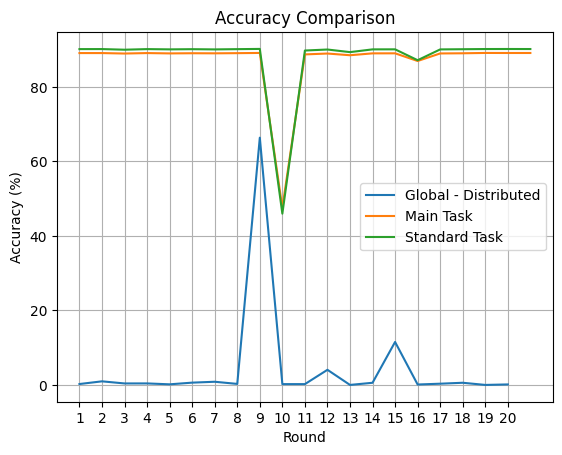

In [27]:
print(len(main_acc_values))# global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_accuracy_distributed = history.metrics_distributed["accuracy"]

# Rút trích thông tin từ dữ liệu
# round_centralised = [data[0] for data in global_accuracy_centralised]
round_distributed = [data[0] for data in global_accuracy_distributed]

# Vẽ đồ thị
# plt.plot(round_centralised, [data[1] for data in global_accuracy_centralised], label="Global - Centralised")
plt.plot(range(1, 22), [data[1] for data in global_accuracy_distributed], label="Global - Distributed")
plt.plot(range(1, 22), main_acc_values, label="Main Task")
plt.plot(range(1, 22), standard_acc_values, label="Standard Task")

# Thiết lập định dạng của biểu đồ
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("Accuracy Comparison")
plt.legend()
xticks_result = plt.xticks(range(1, 21))


history.metrics_centralized = {'accuracy': [(0, 0.1937984496124031), (1, 0.29069767441860467), (2, 0.7751937984496124), (3, 0.29069767441860467), (4, 0.29069767441860467), (5, 0.29069767441860467), (6, 0.29069767441860467), (7, 0.1937984496124031), (8, 0.1937984496124031), (9, 66.95736434108527), (10, 0.29069767441860467), (11, 0.09689922480620156), (12, 2.7131782945736433), (13, 0.29069767441860467), (14, 0.1937984496124031), (15, 9.689922480620154), (16, 0.1937984496124031), (17, 0.09689922480620156), (18, 0.29069767441860467), (19, 0.1937984496124031), (20, 0.1937984496124031)]}


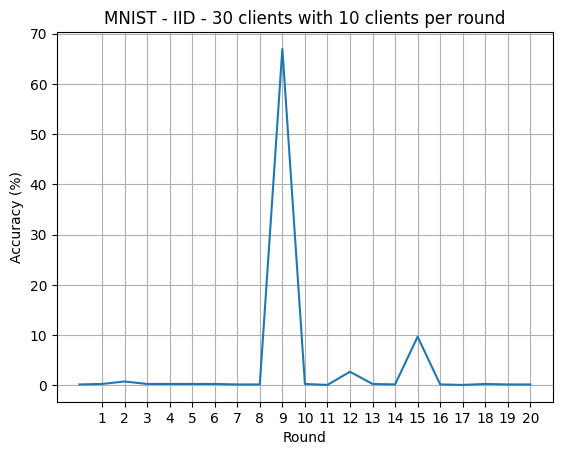

In [28]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")
# print(f"{history.metrics_distributed = }")


global_accuracy_centralised = history.metrics_centralized["accuracy"]
# global_accuracy_centralised = history.metrics_distributed["accuracy"]

round = [data[0] for data in global_accuracy_centralised]
acc = [data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 30 clients with 10 clients per round")
xticks_result = plt.xticks(range(1, 21))
# plt.yticks(range(0, 100))